# Analisis de Mapas II

###  Renée Hložek y Jeff McMahon. Traducción por Cristian Vargas

## Usando nuestras herramientas en mapas reales

En este ejercicio de autoaprendizaje, usaremos algunos datos públicos de la colaboración de ACT, calcularemos los espectros de potencia y los compararemos con los espectros de potencia teóricos.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline
import constantes as cs    # modulo de constantes

from cmb_modulos import * # modulo de funciones

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_ancho =cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_haz_fwhm = cs.tamaño_haz_fwhm

tamaño_pix = cs.tamaño_pix

Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX

Numero_de_Cumulos_SZ = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ
SZ_beta = cs.SZ_beta
SZ_Theta_central = cs.SZ_Theta_central

nivel_de_ruido_blanco = cs.nivel_de_ruido_blanco
nivel_de_ruido_atmosferico = cs.nivel_de_ruido_atmosferico
nivel_de_ruido_1sobref = cs.nivel_de_ruido_1sobref

# Lectura de datos y elaboración de mapas simulados
Comencemos leyendo un mapa y calculando el espectro de potencia del mapa, y luego comparándolo con un mapa teórico de tamaño/forma similar.

0.49491833030853 0.49407681818181814
promedio del mapa: -3.5245380283448906 , media cuadrática (rms) del mapa: 311.228361194383


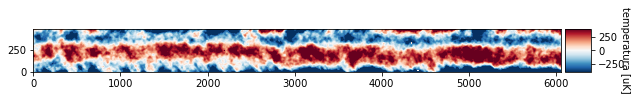

In [2]:
#%cd /Carpeta/donde/estan/los/mapas

mapa = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel en arcominutos
plt.figure(figsize=(10,10))
p = Graficar_Mapa_CMB(mapa,c_min,c_max,Nx,Ny)


Se puede ver que este mapa de ACT es una franja larga, cortaremos un parche cuadrado esta franja y calcularemos el espectro de potencia.

In [3]:
N=int(Ny) # tomamos la dimensión en píxeles del eje y
parche_mapa = mapa[0:int(N), 0:int(N)] #recortamos el mapa en un cuadrado


promedio del mapa: 20.125159755016572 , media cuadrática (rms) del mapa: 124.47878213360549


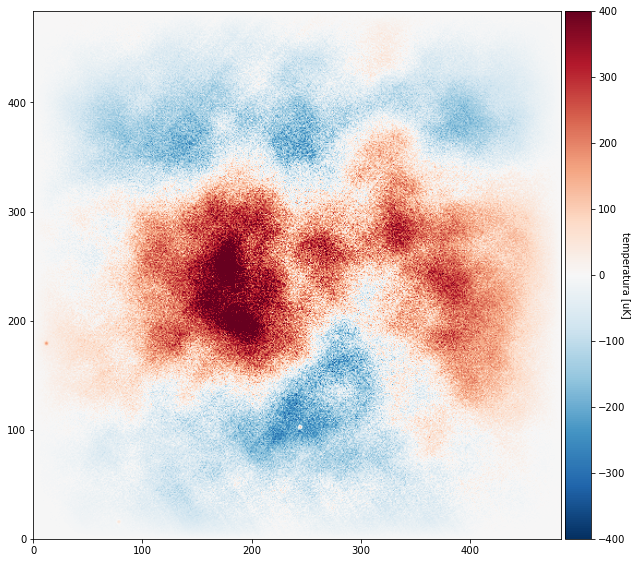

In [4]:
# Aplicando la función ventana
ventana = (ventana_coseno(N))
mapa_apodizado = ventana * parche_mapa
p = Graficar_Mapa_CMB(mapa_apodizado,c_min,c_max,N, N)


### Podemos ver que hay mucha potencia a gran escala proveniente de la atmósfera. ¿Qué esperamos ver en el espectro de potencia?

promedio del mapa: -9.51353494494129 , media cuadrática (rms) del mapa: 43.20843184973311


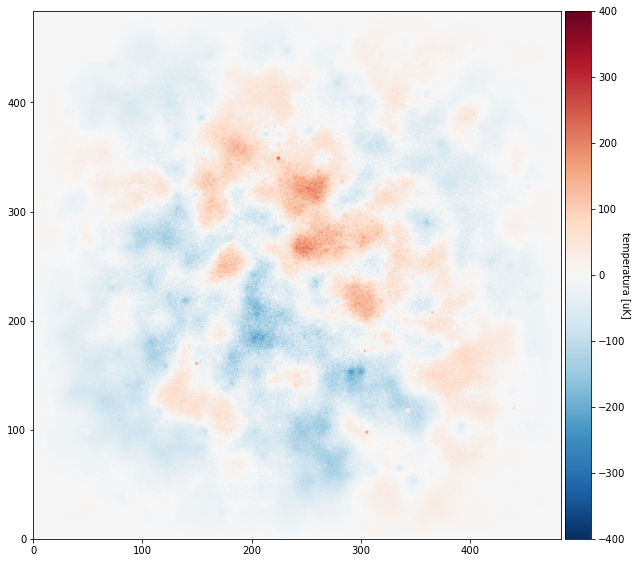

In [5]:
## Hacer un mapa CMB
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

## hacer un mapa de fuentes puntuales
MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
MapaFP += componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)

## hacer un mapa SZ
MapaSZ,catSZ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,Amplitud_promedio_de_cumulos_SZ,
                             SZ_beta,SZ_Theta_central,False)

## agregando todo junto para obtener el mapa del cielo en una sola frecuencia
mapa_total = CMB_T + MapaFP + MapaSZ

## incorporando el impacto del instrumento
    ## haz
CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)
    ## ruido
Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)

mapa_total_mas_ruido = CMB_T_convolucionado + Ruido

## graficar el resultado
#p = Graficar_Mapa_CMB(mapa_total_mas_ruido,c_min,c_max,N,N)

mapa_teorico_apodizado = ventana * mapa_total_mas_ruido

p = Graficar_Mapa_CMB(mapa_teorico_apodizado,c_min,c_max,N, N)

## Ahora tomaremos el espectro de potencia del mapa apodizado y la versión teórica

/Users/cvargas/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cvargas/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


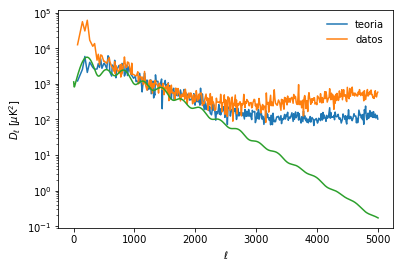

In [6]:
#### parámetros para configurar el espectro
delta_ell = 10 # cs.delta_ell
ell_max = cs.ell_max
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print("ADVERTENCIA: las curvas teoricas terminan antes de ell_max (no están definidas más allá)")
        
ell_bineado_teoria, espectro_bineado_teoria = calcular_espectro_2d(mapa_teorico_apodizado,delta_ell,
                                                                               ell_max,tamaño_pix,N)
ell_bineado_datos, espectro_bineado_datos = calcular_espectro_2d(mapa_apodizado,delta_ell,ell_max,
                                                                                       tamaño_pix,N)

plt.semilogy(ell_bineado_teoria,espectro_bineado_teoria*\
                 ell_bineado_teoria * (ell_bineado_teoria+1.)/2. / np.pi, label='teoria')
plt.semilogy(ell_bineado_datos,espectro_bineado_datos*\
                ell_bineado_datos * (ell_bineado_datos+1.)/2. / np.pi, label='datos')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

Notar que el espectro de potencia está sesgado a gran escala, como esperábamos.
¿Cómo podría eliminar esa potencia a gran escala antes de calcular el espectro de potencia?



<font color='red'>EJERCICIO: </font> Escriba un código para filtrar los modos a gran escala ell < ell_min antes de calcular el espectro de potencia y muestre el espectro para algunos valores diferentes de ell_min. Además, ¿puede pensar en cómo eliminar el poder en escalas pequeñas? Analice la forma de la ventana de apodización y la potencia a gran escala que se filtra a escalas pequeñas.

In [7]:
## Tu código y gráficos van aquí



<font color='red'>EJERCICIO: </font> Recortamos un parche particular de la franja de ACT. Recorta diferentes parches y míralos. Usando el código de espectro de potencia del archivo de módulos, calcula tanto el espectro auto como el cruzado en este mapa. Discute cómo estimarías las barras de error en este espectro de potencia, comparando el espectro de potencia auto con el cruzado. (El espectro auto es cuando usamos un solo parche para calcular el espectro. El espectro cruzado es cuando usamos dos parches distintos)

In [8]:
# Tu código va aquí

<font color='red'>EJERCICIO: </font>  Dado el valor del espectro de potencia que se muestra aquí en escalas pequeñas, podemos estimar el nivel de ruido en los mapas de ACT para esta temporada. Trace curvas de ruido para algunos valores y muéstrelas aquí, y haga un ajuste simple "al ojo" para el nivel de ruido. (La transformada de Fourier del ruido blanco es una constante, por lo que basta con pensar $C_\ell = \mathrm{cte}$ que se traduce en una curva en $D_\ell = \mathrm{cte} \times \ell (\ell + 1)$





In [9]:
# Tu código va aquí

Tu discusión va aquí

<font color='red'>EJERCICIO: </font>  Grafica el espectro de potencia 2D, tanto el de teoría de entrada + ruido como el de los datos de ACT. ¿Qué te dice esto sobre el ruido real en experimentos de CMB?

In [10]:
## Tu código va aquí

## Dependencia en frecuencia de los mapas y fuentes 

Ahora vamos a ver mapas de ACT en una misma porción del cielo, pero en una banda de frecuencia diferente.

0.49491833030853 0.49407681818181814
promedio del mapa: -35.148097186618045 , media cuadrática (rms) del mapa: 319.0813587167169


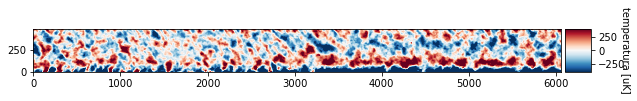

In [11]:
mapa220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel en arcominutos
plt.figure(figsize=(10,10))
p = Graficar_Mapa_CMB(mapa220,c_min,c_max,Nx,Ny)


/Users/cvargas/miniforge3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/cvargas/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


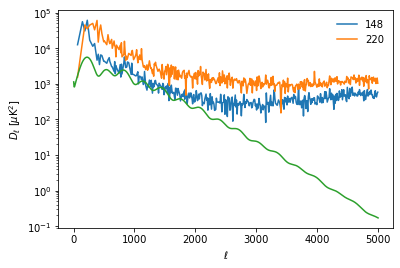

In [12]:
N=int(Ny) 
mapa_parche220 = mapa220[0:int(N), 0:int(N)] 
ventana = (ventana_coseno(N))
mapa220_apodizado = ventana * mapa_parche220

ell_bineado_datos220, espectro_bineado_datos220 = calcular_espectro_2d(mapa220_apodizado,delta_ell,ell_max,
                                                                                              tamaño_pix,N)
plt.semilogy(ell_bineado_datos,
             espectro_bineado_datos*ell_bineado_datos*(ell_bineado_datos+1.)/2. / np.pi, label='148')
plt.semilogy(ell_bineado_datos220,
             espectro_bineado_datos220* ell_bineado_datos220*(ell_bineado_datos220+1.)/2./np.pi,label='220')

#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EJERCICIO: </font> El espectro está sesgado debido a fuentes puntuales en todas las escalas. Use el código del cuadernillo anterior para determinar el sesgo de ruido para este espectro y eliminarlo.


In [13]:
## Tu código va aquí

<font color='red'>EJERCICIO: </font> Aplicar las técnicas de la Parte Cinco y buscar fuentes puntuales y conglomerados SZ en el mapa

In [14]:
## Tu código va aquí